**By Peter A. Stokes, École Pratique des Hautes Études – Université PSL**

These are brief notes and exercises on working with images using Python. They are intended as complements to classroom teaching. They assume a a basic level of Python programming. This notebook also assumes that the relevant SciKit libraries have already been installed in your Python system. It also assumes that you have already completed 1. Basic Image Manipulation with SciKit-Image.

_If you are viewing this in Jupyter then you can edit the code simply by typing in the boxes. You can also execute the code in any box by clicking on the box and typing SHIFT + ENTER or using the 'Run' button in the menubar above._

The goal of this notebook is to use the Scikit-Image library to analyse an image of (a section of) a page of a manuscript, and to isolate the text written in red. In order to do this, we need to think very carefully about the nature of the image and of the different channels, and to do some calculations using these channels. We will also see some tricks at the end to improve our results.

# The Process

As always, we start with the imports. Here, we only need a couple of different libraries: `matplotlib`, which we saw previously for showing our results, `skimage.io` for loading our image, some filters for thresholding our image (detecting which regions are rubrics and which are not), and some further libraries for processing the arrays that contain our image.

In [1]:
from scipy import ndimage
from skimage import io
from skimage.filters import try_all_threshold, threshold_li
from skimage.morphology import area_opening
from matplotlib import pyplot as plt
from numpy import bitwise_xor

Now we load the image and select a region. Loading the image is straightforward, as we saw in the previous notebook. We select a part of the image (a region of interest) mainly so that the code runs faster and is clearer what it's doing, but of course you could run it on the whole image if you wish.

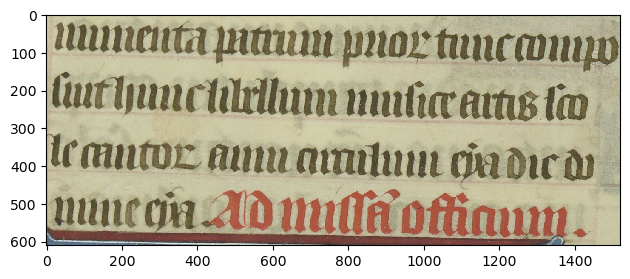

In [2]:
im_addr = "https://gallica.bnf.fr/iiif/ark:/12148/btv1b10024153f/f35/full/full/0/native.jpg"

im = io.imread(im_addr)

im_region = im[2150:2760, 580:2100, :]
io.imshow(im_region)

Now, let's have a look at the three colour channels (red, green and blue). Look very carefully at the results, particularly for the rubric. You will see that the rubric is almost invisible in the red channel, but is very clear in the green and blue channels. Why is this? Be sure that you understand why before going on, as this is crucial for the whole exercise.

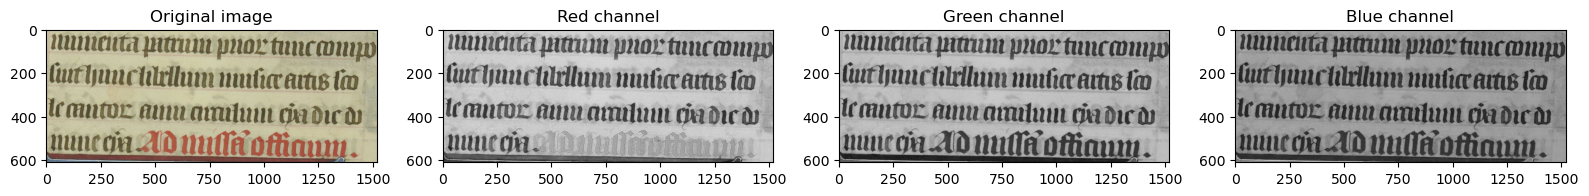

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(im_region)
ax[0].set_title("Original image")
ax[1].imshow(im_region[:,:,0], cmap=plt.cm.gray)
ax[1].set_title("Red channel")
ax[2].imshow(im_region[:,:,1], cmap=plt.cm.gray)
ax[2].set_title("Green channel")
ax[3].imshow(im_region[:,:,2], cmap=plt.cm.gray)
ax[3].set_title("Blue channel")

fig.tight_layout()
plt.show()

If we want to isolate a specific part of the image (here, the rubrics), then one way to do this is to create two images which are identical in all ways except for the part that we want to isolate. Once we have this then we can subtract one image from the other, and all that will be left is the part that we want. **Do you understand why? Think about this carefully and be sure it's clear before going on.**

Here, we have two images which almost meet our criteria: the red channel and one of either the green or blue channel images. This suggests that we can subtract the red from the green (or blue) to get what we need. However, the results are not yet perfect, and it would be better if we can get something cleaner. In particular, you can see the rubrics very faintly in the red channel image, and it would be best if we can remove these. 

One way to do this is to binarize the images. This means that we calculate a threshold value, and all pixels which are above this value are set to white, and all pixels below this value are set to black. If we do this properly then the faint rubrics in the red channel will disappear. This also has the advantage that it will remove slight differences in the background and ink of the red channel and the green channel, as everthing will be either black or white.

The challenge with binarization is calculating which threshold to use. Fortunately, scikit-image helps us here as it includes `try_all_threshold` which applies all of the different threshold methods that it knows, and lets us see which one works the best for us. Let's use this on our red channel image:

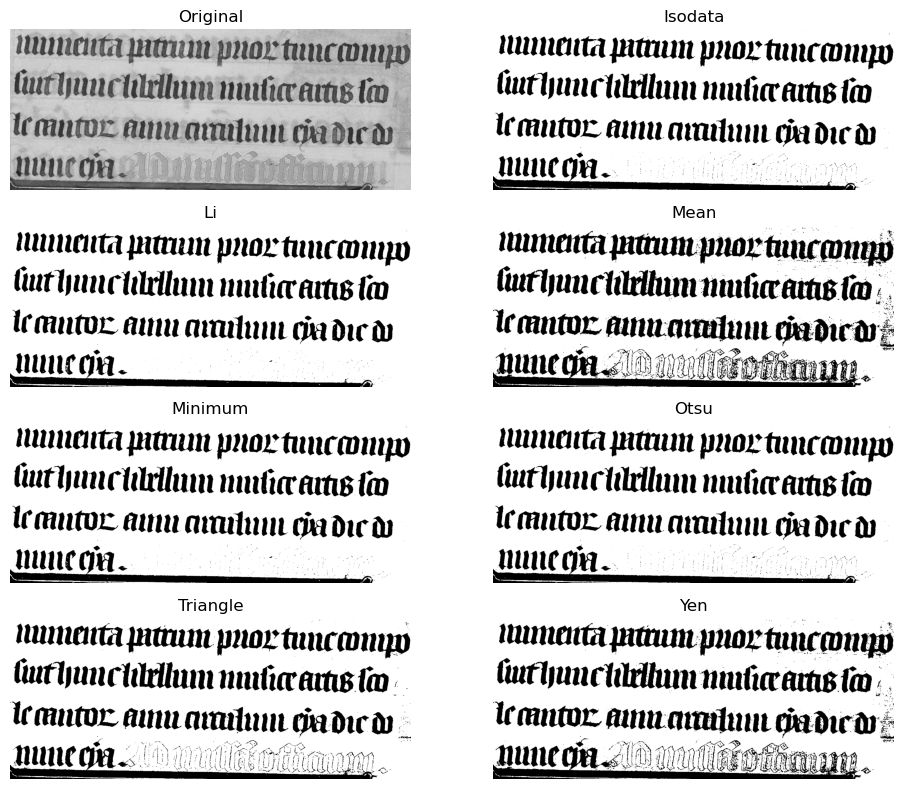

In [4]:
fig, ax = try_all_threshold(im_region[:,:,0], figsize=(10, 8), verbose=False)
plt.show()

As you can see, the results are very different: in some cases, the rubric is very clear, and in others it is invisible. It looks like `minimum` or `li` are the most promising here. Let's try it on the green channel.

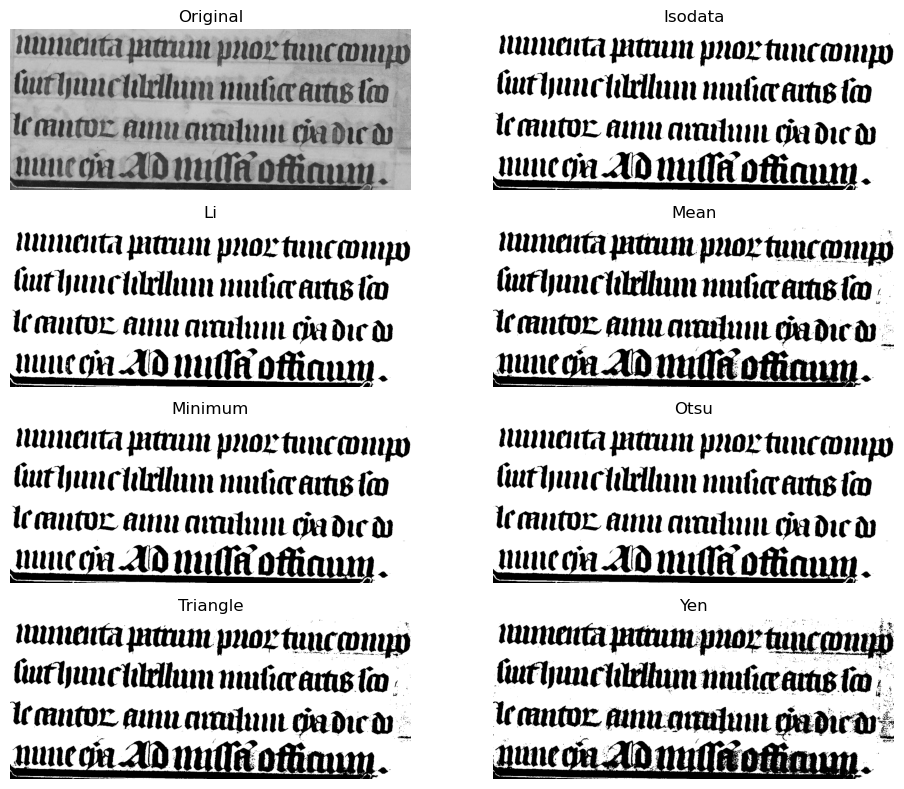

In [5]:
fig, ax = try_all_threshold(im_region[:,:,1], figsize=(10, 8), verbose=False)
plt.show()

This looks promising, as again the `minimum` and `li` thresholding methods give pretty clear images that isolate the black text and the rubrics against a white background. Let's try using the `li` method on our images.

In [6]:
thresh_red = threshold_li(im_region[:,:,0])
thresh_blue = threshold_li(im_region[:,:,2])

print("Thresholds calculated at", thresh_red, "(red) and", thresh_blue, "(blue)")

Thresholds calculated at 138.90791137801227 (red) and 100.16042578138337 (blue)


We now know that for the red channel, we want all pixels that are above this red value to be white, and all pixels below this to be black. The same then goes for the blue value applied to the blue channel.

This is all very nice, but how do we do this in practice? We could easily use two `for` loops, to iterate over our image pixel by pixel, check if the pixel is higher or lower than the threshold, and record the results. As an exercise, you should try doing this: it's not difficult, but it is a bit fiddly, and it would be better to have an easier solution.

Fortunately, we do have a solution which is both easier and *much* faster. As you know, images in scikit have the type Numpy `ndarray`. These `ndarray`s are very powerful, and allow us to work on the images very efficiently, both in terms of programming effort and in terms of how quickly it runs on the computer. For instance, we can use the 'greater than' operator > to compare an `ndarray` and a simple float value. Let's try this and look at the result

In [7]:
bin_red = im_region[:,:,0] > thresh_red
bin_blue = im_region[:,:,2] > thresh_blue

print(bin_red[25:35, 25:35])

[[ True  True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True False False False False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]]


As you can see, we have a new `ndarray`, where the value of the array is `True` if the equivalent pixel was above the threshold, and `False` if it was not. What's more, we can ask `matplotlib` to plot a graph of this new `ndarray`, where `True` values are white and `False` values are black. To do this, we have to give it a colour map, in order to tell it which colour should be used for `True` and which for `False`. The normal one to use here is `gray`, and so we can now do this.

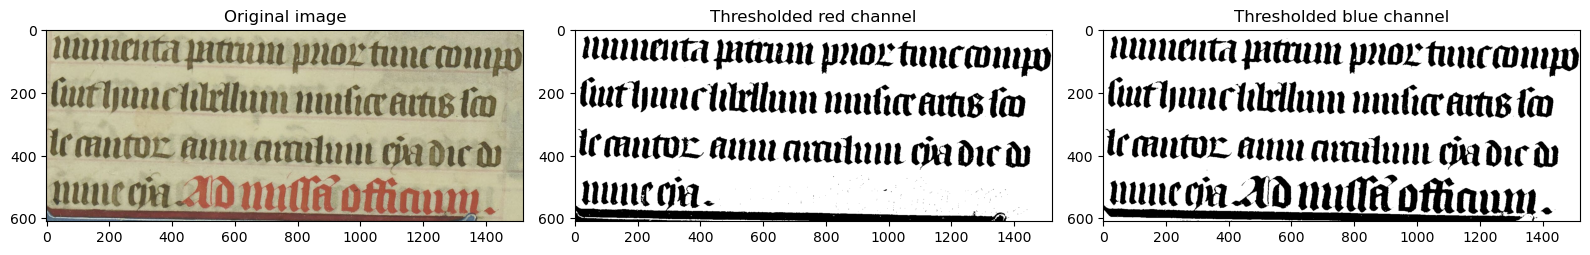

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(im_region)
ax[0].set_title("Original image")
ax[1].imshow(bin_red, cmap=plt.cm.gray)
ax[1].set_title("Thresholded red channel")
ax[2].imshow(bin_blue, cmap=plt.cm.gray)
ax[2].set_title("Thresholded blue channel")

fig.tight_layout()
plt.show()

The trick now is to use these two images to isolate just the rubric. There are different ways of doing this, but one is to use boolean logic. Let's think about the different cases here. What we want is to see the difference between the red and blue channels. In other words, if the red and the blue channel are both the same colour then we want the result to be black. If the red and blue channels are different colours, then the result should be white. We can even break this down further to consider all the different cases, as follows:

1. The red channel is white (True) and the blue channel is white (True): result should be black (False)
1. The red channel is black (False) and the blue channel is black (False): result should be black (False)
1. The red channel is white (True) and the blue channel is black (False): result should be white (True)
1. The red channel is black (False) and the blue channel is white (True): result should be white (True)

Again, we could do this the hard way by using `for` loops to go through the arrays element by element, and then check these different conditions (and it would be a good exercise to try this). However, again, there is a much more efficient way of doing this. If you know your boolean logic (and you should!) then you will see that what we have here is an 'exclusive or' condition (often abbreviated to XOR). An 'exclusive or' is true only if A *or* B is true *but not both*. And, fortunately again, the `numpy` library gives us a way to do a value-by-value exclusive or operation on an ndarray. This is how it works.

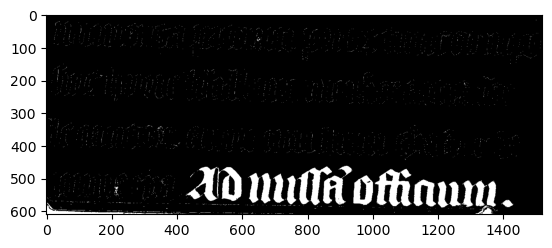

In [9]:
rubric = bitwise_xor(bin_red, bin_blue)

plt.imshow(rubric, cmap="gray")

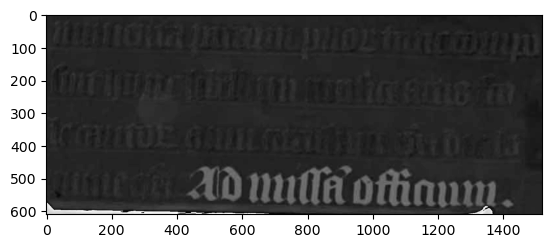

In [10]:
test = im_region[:,:,0] - im_region[:,:,2]
plt.imshow(test, cmap="gray")

## Improving the results

We now have a pretty good result: the rubric is clearly there, and the rest of the image is (mostly) gone. However, there are a few small dots that are scattered around, and it would be better if we can get rid of these as well. There are different ways of doing this, but one possibility is to try blurring the image. This sounds counter-intuitive, since blurring normally means reducing the quality, but it can help to 'smooth over' small bits of noise like we have here.

Blurring is another big topic in Computer Vision and we won't go into this here; just take my word for it that a common option is the so-called Gaussian filter which is provided in the `scipy.ndimage` library. Here we will use the `sigma` parameter: to keep a long story short, the higher the value of `sigma` the more the image is blurred.

Let's try using this on the red channel image. Try adjusting the value of sigma to see what happens.

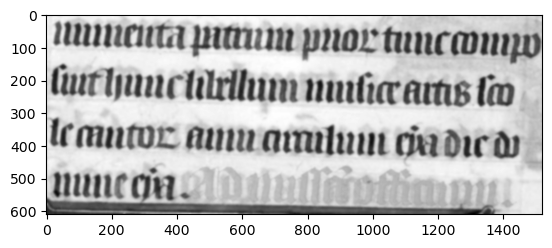

In [11]:
im_blur = ndimage.gaussian_filter(im_region[:,:,0], sigma=3)
plt.imshow(im_blur, cmap='gray')

Now, let's try repeading our code from above, but with the difference that we will blur the red and blue channel images before calculating the threshold. Other than the first two lines, the code here is absolutely identical to what we had above. (As a further exercise, try blurring the colour image first, then separating it into channels.)

Thresholding at 140.55163577850544 (red) and  98.59457393114415 (blue)


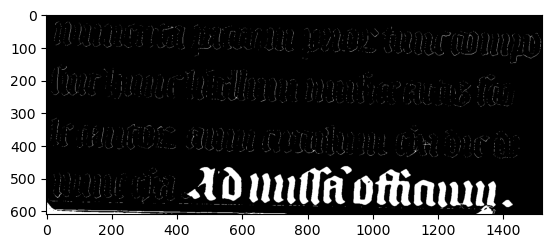

In [12]:
blur_red = ndimage.gaussian_filter(im_region[:,:,0], sigma=2)
blur_blue = ndimage.gaussian_filter(im_region[:,:,2], sigma=2)

thresh_red = threshold_li(blur_red)
thresh_blue = threshold_li(blur_blue)

print("Thresholding at", thresh_red, "(red) and ", thresh_blue, "(blue)")

bin_red = blur_red > thresh_red
bin_blue = blur_blue > thresh_blue

rubric = bitwise_xor(bin_red, bin_blue)

plt.imshow(rubric, cmap="gray")

Did that help here? Why (or why not)? What about blurring the final resulting image? (Try it, but be warned as it's not quite as easy as it looks! What does it mean to blur `True` and `False`?)

Another standard approach in computer vision is to use so-called morphological operators such as 'opening'. To keep things short for now, a morphological opening is an operation which is designed to remove small regions while keeping large ones. We can control just how large or small by adjusting the parameter `area_threshold`. This is how it works.

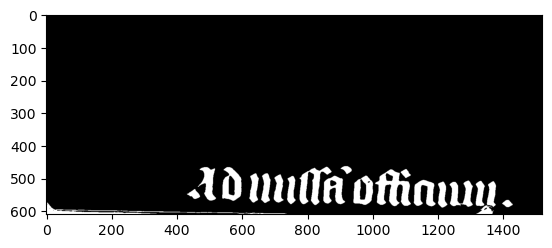

In [13]:
opened = area_opening(rubric, area_threshold=64)
plt.imshow(opened, cmap="gray")

Is that any better? Try adjusting `area_threshold` to see what happens, and see how good a result you can get.

We can also improve the results even further. Notice here that there is some white/True pixels along the bottom of the image. This is from a line in the original manuscript image (you probably didn't even notice, but look carefully, it's there!). It's fairly common in image processing that the borders are different from the rest of the image, and this can often cause problems in the results. For this reason, skimage gives us `clear_boder` which will remove borders for us.

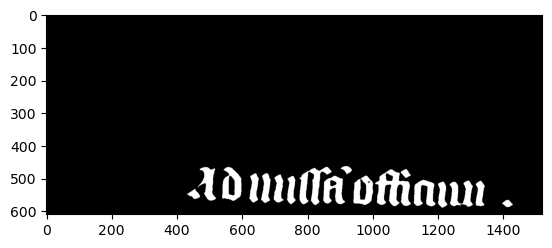

In [14]:
from skimage.segmentation import clear_border
cleared = clear_border(opened)
plt.imshow(cleared, cmap="gray")

## Taking it further: Labelling regions

As a taster for taking this further, here is an example of [region labelling](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html). This could be used, for instance, to measure how much the scribe connected the different strokes of the letters, and this could then be used (for instance) to judge automatically how cursive a script is on a manuscript page. You will need to search online to see how it works and understand how to use it, but it opens some interesting possibilities.

Enjoy!

18 distinct regions detected in rubrics


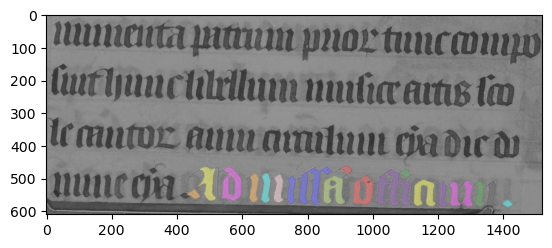

In [15]:
from skimage.measure import label
from skimage.color import label2rgb

label_image = label(cleared)
print(label_image.max(), "distinct regions detected in rubrics")

image_label_overlay = label2rgb(label_image, image=im_region, bg_label=0)
plt.imshow(image_label_overlay)

---
![Licence Creative Commons](https://i.creativecommons.org/l/by/4.0/88x31.png)
This work (the contents of this Jupyter Python notebook) is licenced under a [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)